## Introduction to Missing Data Diagnostics and Treatment

### Speaker: Ricardo J. Serrano

### Objectives

*  What is missing data?

*  Missing data mechanisms (MCAR, MAR, MNAR)

*  How to treat missing data the right way

### What is missing data?

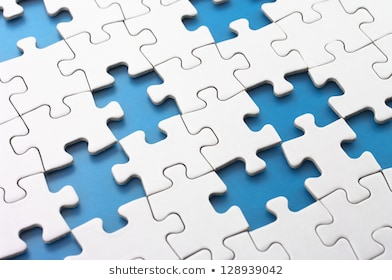

### Missing Data Mechanisms

*  Missing Completely at Random (MCAR)

*  Missing at Random (MAR)

*  Missing Not at Random (MNAR)

Source: Rubin (1976)

### Missing Completely at Random (MCAR)

*  Locations of missing values in the dataset are purely random, they do not depend on any other data.

*  Example: A weather sensor is measuring temperature and sending the data to a database. There are some missing entries in the database for when the sensor broke down.

### Missing at Random (MAR)

*  Locations of missing values in the dataset depend on some other, observed data.

*  There are some missing temperature values in the database for when the sensor was switched off for maintenance. As the maintenance team never work on the weekends, the locations of missing values depend on the day of the week.

### Missing Not at Random (MNAR)

*  Locations of missing values in the dataset depend on the missing values themselves.

*  When it's extremely cold, the weather sensor freezes and stops working. So, it does not record very low temperatures. Thus, the locations of missing values in the temperature variable depend on the values of this variable themselves.

### Why detecting the missing data mechanism is important?

*  Imputation methods make assumptions on the type of missing data mechanism.

*  Justifies the strategy to deal with missing data.

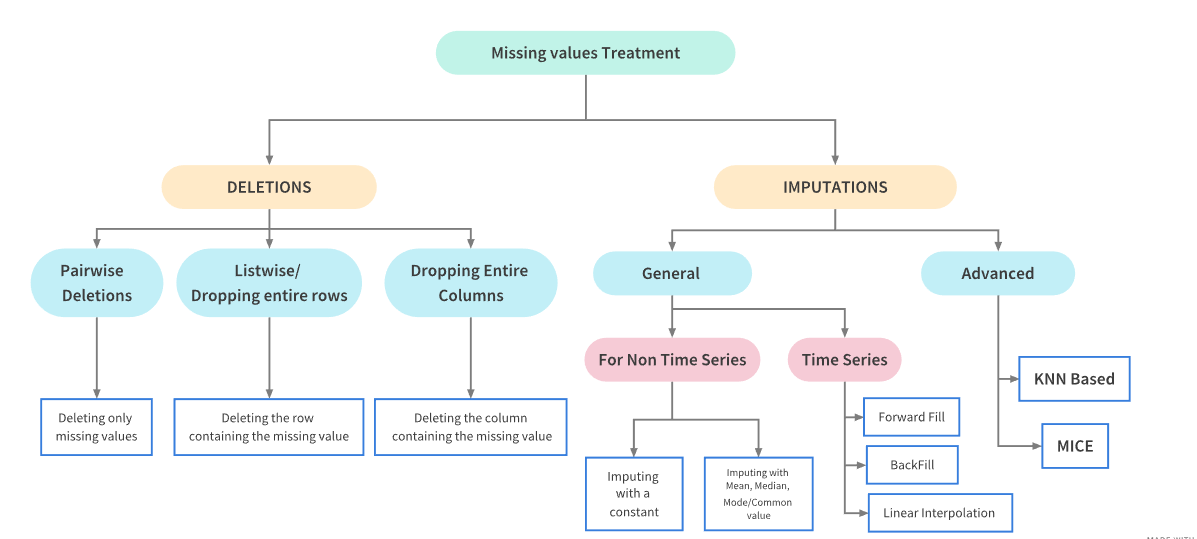

### How can the missing data mechanisms be detected?

*  Data visualization

*  Statistical tests

In [1]:
# import libraries
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# import library
import datawig

# supress warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,10)

In [2]:
# read the Titanic dataset
df = pd.read_csv("./data/titanic.csv")

In [3]:
df.shape

(1309, 14)

In [4]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,Allen Miss. Elisabeth Walton,female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,St Louis MO
1,1,1,Allison Master. Hudson Trevor,male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,Montreal PQ / Chesterville ON
2,1,0,Allison Miss. Helen Loraine,female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal PQ / Chesterville ON
3,1,0,Allison Mr. Hudson Joshua Creighton,male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,Montreal PQ / Chesterville ON
4,1,0,Allison Mrs. Hudson J C (Bessie Waldo Daniels),female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal PQ / Chesterville ON


In [5]:
df.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3,0,Zabour Miss. Hileni,female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,Zabour Miss. Thamine,female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,Zakarian Mr. Mapriededer,male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,Zakarian Mr. Ortin,male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,Zimmerman Mr. Leo,male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [7]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [8]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# verify missing values
missing_values_table(df)

2020-12-02 16:35:54,789 [INFO]  Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-02 16:35:54,789 [INFO]  NumExpr defaulting to 8 threads.


Your selected dataframe has 14 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
body,1188,90.8
cabin,1014,77.5
boat,823,62.9
home.dest,564,43.1
age,263,20.1
embarked,2,0.2
fare,1,0.1


In [10]:
# drop unnecessary features
df.drop(['body', 'boat', 'home.dest'], axis=1, inplace=True)

Three features have missing values present: `Cabin`, `Age`, `Embarked` and `Fare`.

### Exploring missing data with `missingno` library

<AxesSubplot:>

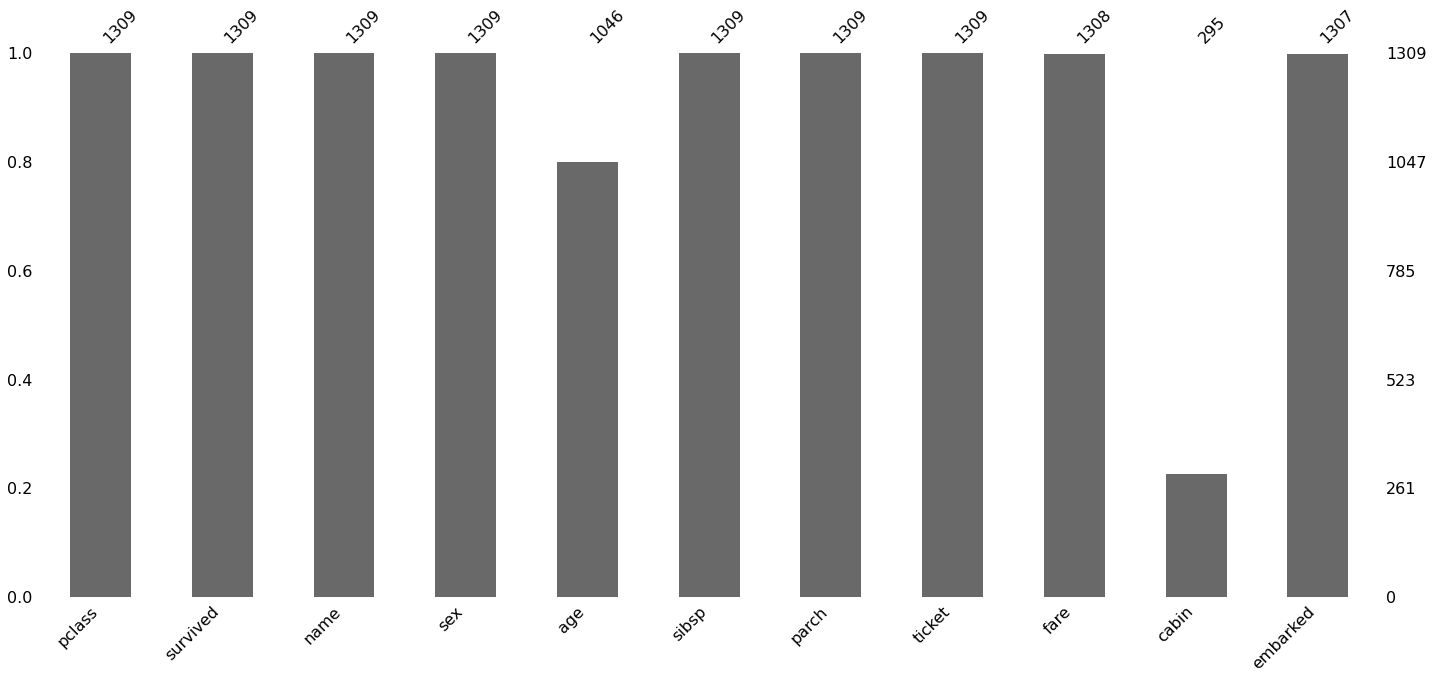

In [11]:
msno.bar(df)

<AxesSubplot:>

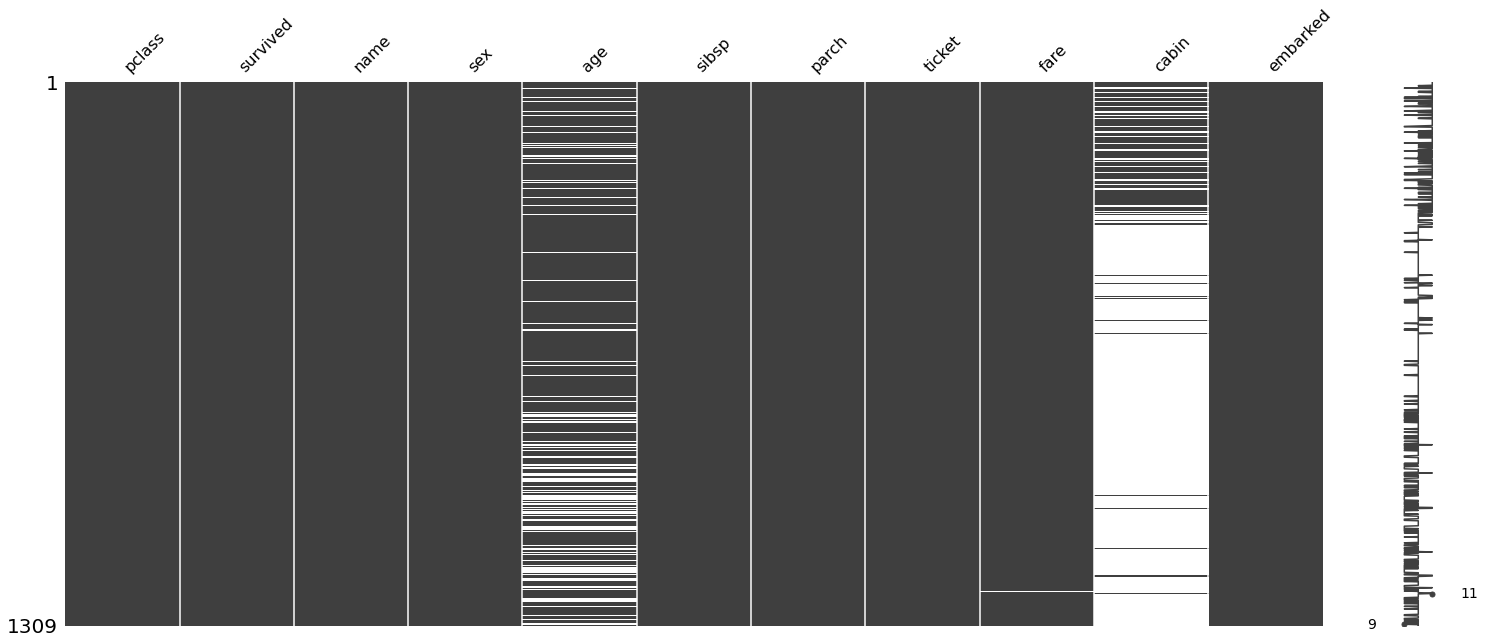

In [12]:
msno.matrix(df)

<AxesSubplot:>

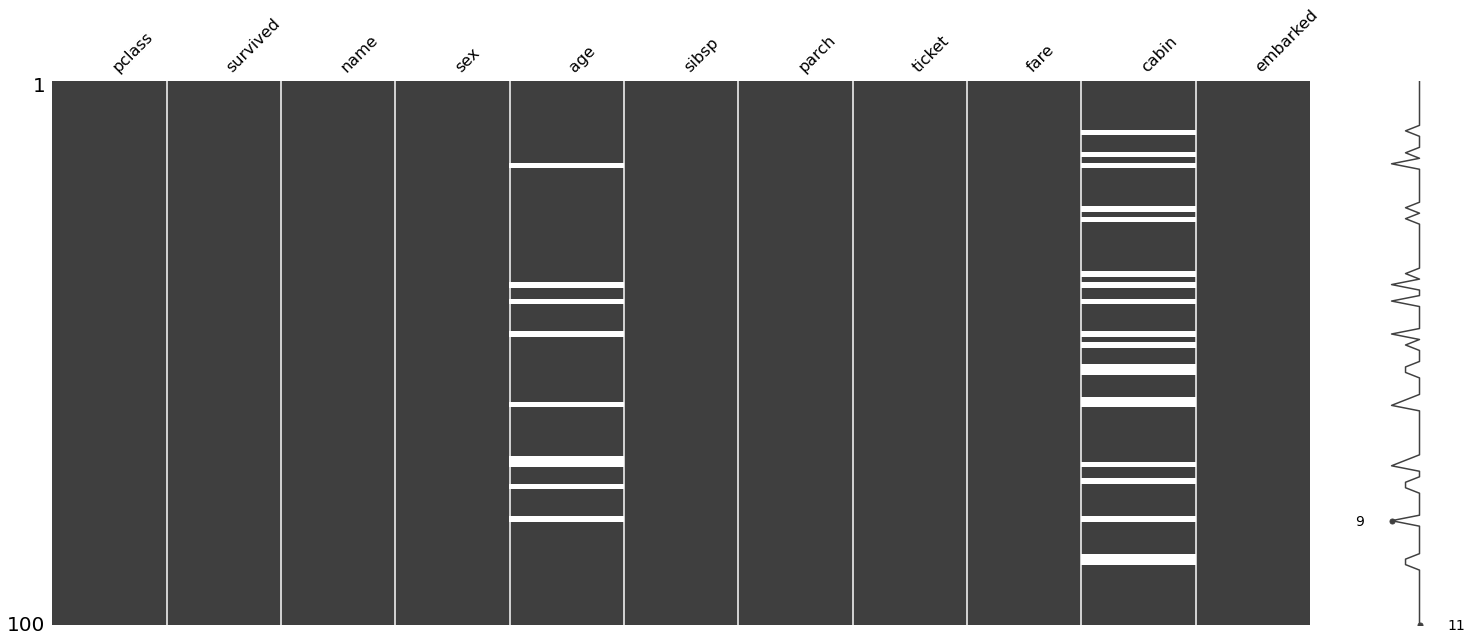

In [13]:
# visualize missing values for first 100 rows
msno.matrix(df.loc[:99, ])

### What do you notice regarding missing values distribution?

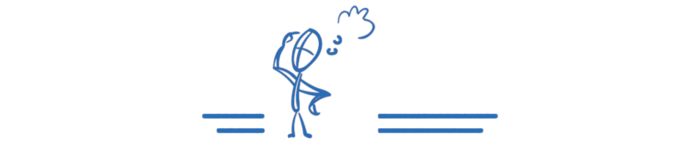

*  `embarked` and `fare` feature seems to quality for MCAR, since there is no apparent relationship with other features.

*  `cabin` and `age` could be classified as MAR (there is no direct cause for missingness based on the observed values).

### What about MCAR?

*  In R, the `BaylorEdPsych` library provides a test for MCAR (LittleMCAR). However, this library is not currently maintained (use at your own <span style="color:red">risk!</span>).

*  IBM/SPSS commercial package provides a test for MCAR.

*  To my knowledge, there is no implemtation in Python to test MCAR assumption.

<AxesSubplot:>

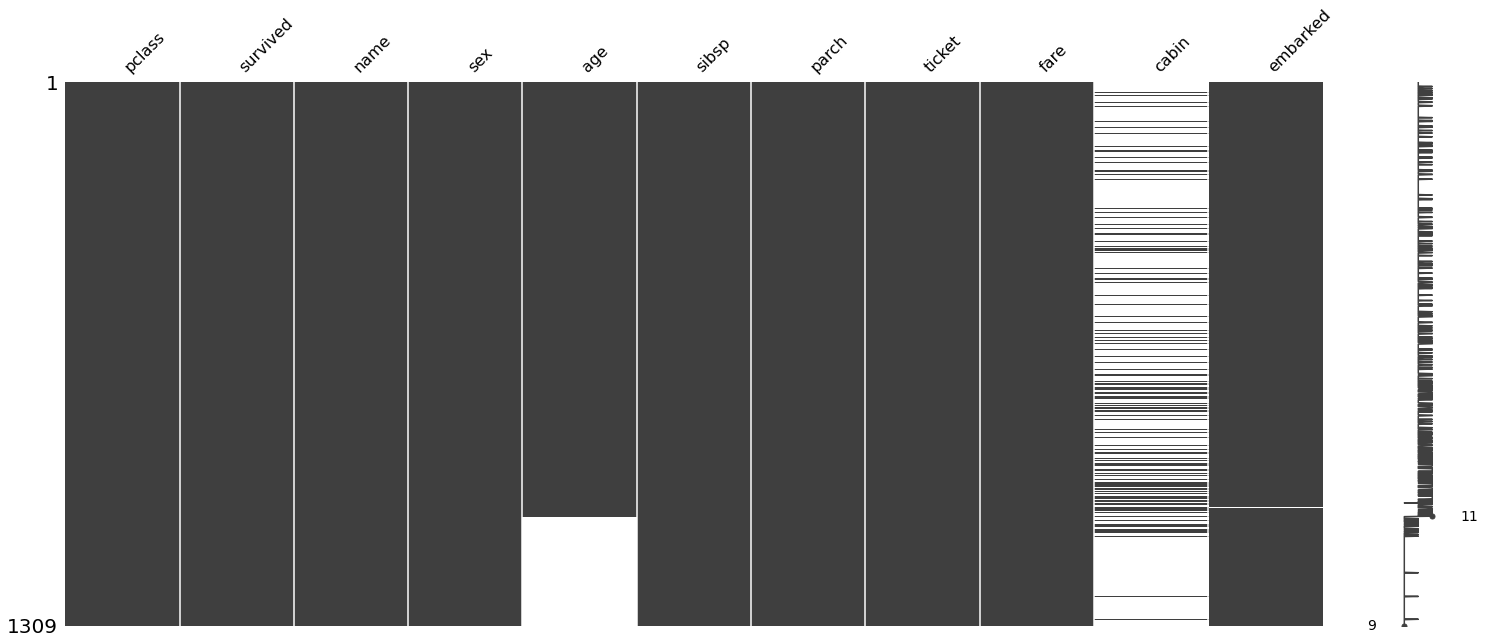

In [14]:
# `age` (sorted) and `cabin` plot
sorted = df.sort_values('age')
msno.matrix(sorted)

### Heatmap

*  In `msno`, the heatmap function shows the correlation of missingness between every 2 columns.

*  A value near `-1` means if one variable appears then the other variable is very likely to be missing.

*  A value near `0` means there is no dependence between the occurrence of missing values of two variables. A value near 0 is an indication of MAR.

*  A value near `1` means if one variable appears then the other variable is very likely to be present.

<AxesSubplot:>

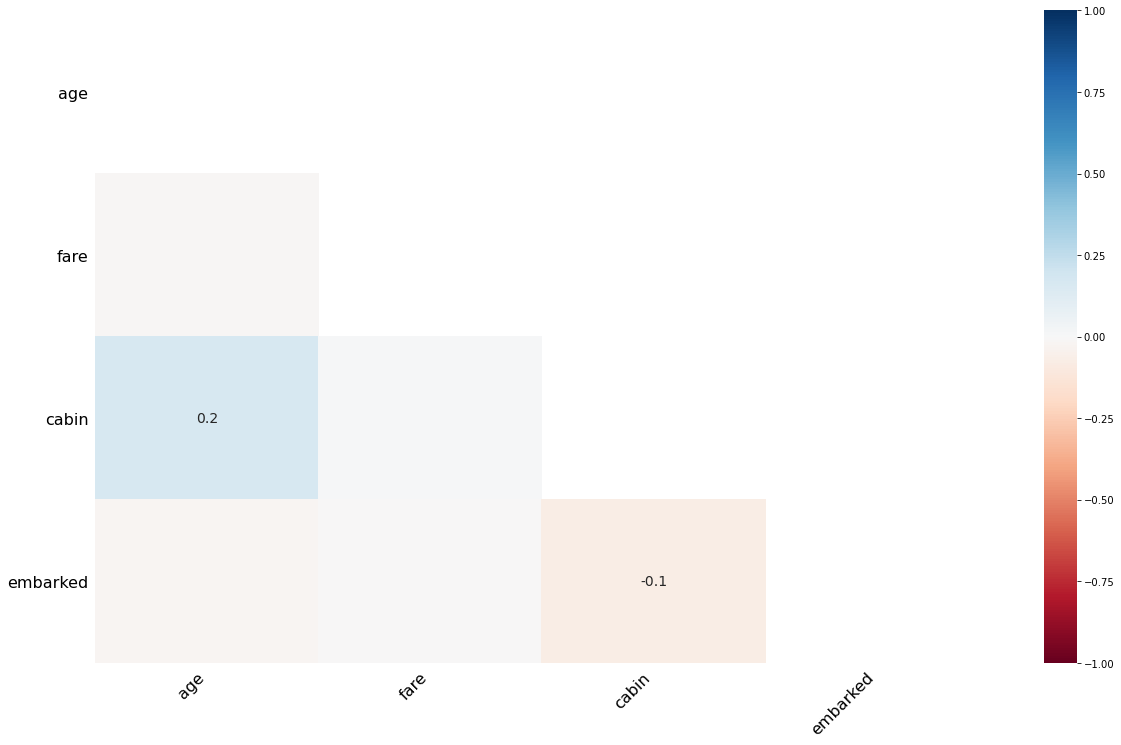

In [15]:
# heatmap
msno.heatmap(df)

There is no strong correlation between `cabin` and `age`, pointing to `MAR` mechanism.

### Imputing missing values

*  `embarked` - only two missing values. Assuming MCAR. Proposed impute methodology: mode imputation.

*  `cabin` - 77% missing values. In practical terms, this feature will be a candidate for column deletion. An alternate strategy will be to use `mice` to impute the cabin first letter.

*  `age` - ~20% missing values. From extensive EDA done by data scientists, this feature is a valuable predictor for the target (`Survived`). The strategy is to use model-based approach (i.e. mice) to impute this feature.

*  `fare` - only one missing value. Assuming MAR. Since `age` is imputed using model-based approach and `Fare` is numeric, let the model impute the missing value.

### Imputing `embarked`

In [16]:
df_imp = df.copy()

In [17]:
# `embarked` value count
df_imp.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [18]:
# use fillna to impute `embarked` missing values with mode ('S')
df_imp['embarked'].fillna(df_imp.embarked.mode()[0], inplace=True)

In [19]:
df_imp['embarked'].isnull().sum()

0

### Create `title` feature

In [20]:
df_imp['title'] = df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [21]:
df_imp.title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Major         2
Ms            2
Don           1
Jonkheer      1
Lady          1
Dona          1
Sir           1
Capt          1
Mme           1
Countess      1
Name: title, dtype: int64

In [22]:
# replace several titles with rare_title category
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

df_imp['title'] = np.where(df_imp['title'].isin(rare_title), 'Rare Title', df_imp['title'])

# replace Mlle and Ms with Miss
df_imp['title'] = np.where(df_imp['title'].isin(['Mlle', 'Ms']), 'Miss', df_imp['title'])

# replace Mme with Mrs
df_imp['title'] = np.where(df_imp['title'].isin(['Mme']), 'Mrs', df_imp['title'])

In [23]:
df_imp.title.value_counts()

Mr            757
Miss          264
Mrs           198
Master         61
Rare Title     29
Name: title, dtype: int64

### Imputing `cabin`

In [24]:
# extract first `cabin` letter, create `deck` feature
df_imp['deck'] = df_imp['cabin'].str[0]

In [25]:
# drop unnecessary features for imputing
df_imp.drop(['name', 'ticket', 'cabin'], axis=1, inplace=True)

In [26]:
df_imp.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck
0,1,1,female,29.0000,0,0,211.3375,S,Miss,B
1,1,1,male,0.9167,1,2,151.5500,S,Master,C
2,1,0,female,2.0000,1,2,151.5500,S,Miss,C
3,1,0,male,30.0000,1,2,151.5500,S,Mr,C
4,1,0,female,25.0000,1,2,151.5500,S,Mrs,C


In [27]:
# output to csv
# df_imp.to_csv('df_imp.csv', index=False)

In [28]:
df_imp.deck.value_counts(dropna=False)

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: deck, dtype: int64

<AxesSubplot:xlabel='title', ylabel='age'>

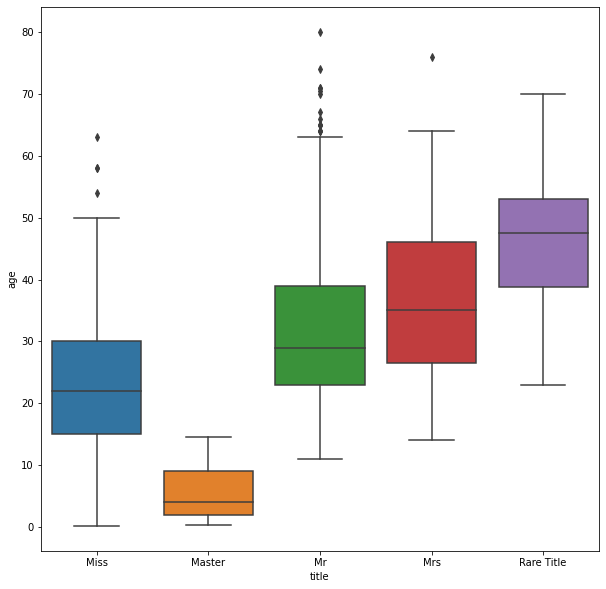

In [29]:
# explore relationship between `title` and `age`
sns.boxplot(data=df_imp, x='title', y='age')

In order to statistically test the significance of the relationship between `age` and `title`, a one-way ANOVA test is warranted. The F-statstic is the indicator for significance: p-value < 0.05 indicates **there is a  significant evidence of relationship between the two features**.

In [30]:
# one-way ANOVA for `age` and `title`
mod = ols('age ~ (title)', data = df_imp).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     108.0
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           5.39e-77
Time:                        16:36:56   Log-Likelihood:                -4093.1
No. Observations:                1046   AIC:                             8196.
Df Residuals:                    1041   BIC:                             8221.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.4827      1.668      3.288      0.001       2.210       8.755
title[T.Miss]          16.3416      1.864      8.769      0.000      12.685      19.998
title[T.Mr]            26.7694      1.742     15.367      0.000      23.351      30.188
title[T.Mrs]           31.4354      1.909     16.470      0.000      27.690      35.181
title[T.Rare Title]    39.6959      2.836     13.995      0.000      34.130      45.262
==============================================================================
Omnibus:                       91.078   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.687
Skew:                           0.767   Prob(JB):                     2.06e-25
Kurtosis:                       3.506   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# one-way ANOVA for `title` and `age`
F, p = stats.f_oneway(df_imp.loc[df_imp['title'] == 'Miss', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Master', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Mr', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Mrs', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Rare Title', 'age'].dropna()
                     )

print("F-statistic: ",np.round(F,4), "\n","P-value   : ",np.round(p,4))

F-statistic:  107.9818 
 P-value   :  0.0


In [32]:
# Kruskal-Wallis nonparametric test
stats.kruskal(df_imp.loc[df_imp['title'] == 'Miss', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Master', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Mr', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Mrs', 'age'].dropna(), 
             df_imp.loc[df_imp['title'] == 'Rare Title', 'age'].dropna()
             )

KruskalResult(statistic=286.47007231230634, pvalue=8.971910857764332e-61)

The F-statistic and Kruskal-Wallis tests values are less than 0.05 (95% confidence), indicating that `age` and `title` groups differences are significant (i.e. there is a significant relationship between these features).

<AxesSubplot:xlabel='deck', ylabel='fare'>

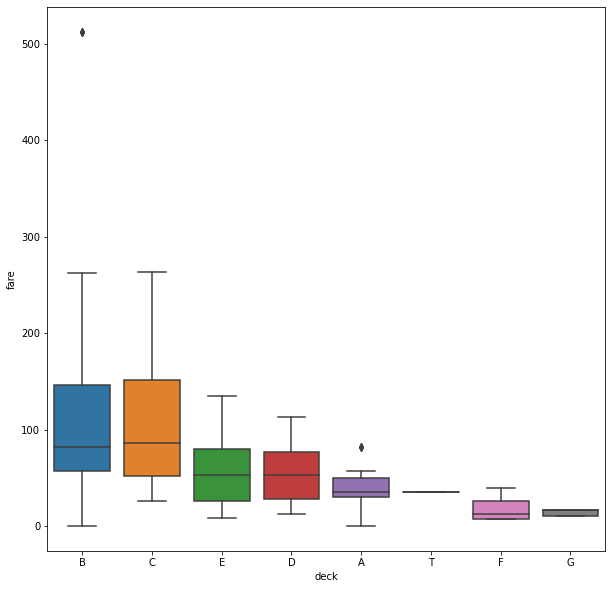

In [33]:
# explore relationship between `deck` and `fare`
sns.boxplot(data=df_imp, x='deck', y='fare')

In [34]:
# one-way ANOVA for `fare` and `deck`
mod = ols('fare ~ (deck)', data = df_imp).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     10.92
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           3.16e-12
Time:                        16:37:03   Log-Likelihood:                -1672.3
No. Observations:                 295   AIC:                             3361.
Df Residuals:                     287   BIC:                             3390.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.2443     15.152      2.722      0.007      11.422      71.067
deck[T.B]     81.1388     17.529      4.629      0.000      46.636     115.641
deck[T.C]     66.6823     16.832      3.962      0.000      33.553      99.811
deck[T.D]     11.7630     18.422      0.639      0.524     -24.496      48.022
deck[T.E]     13.3203     18.782      0.709      0.479     -23.647      50.288
deck[T.F]    -23.1649     21.681     -1.068      0.286     -65.840      19.510
deck[T.G]    -27.0393     35.209     -0.768      0.443     -96.341      42.262
deck[T.T]     -5.7443     72.665     -0.079      0.937    -148.768     137.280
==============================================================================
Omnibus:                      157.683   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1077.793
Skew:                           2.114   Prob(JB):                    9.12e-235
Kurtosis:                      11.355   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# one-way ANOVA for `deck` and `fare`
F, p = stats.f_oneway(df_imp.loc[df_imp['deck'] == 'A', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'B', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'C', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'D', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'E', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'F', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'G', 'fare'].dropna())

print("F-statistic: ",np.round(F,4), "\n","P-value   : ",np.round(p,4))

F-statistic:  12.6729 
 P-value   :  0.0


In [36]:
# Kruskal-Wallis nonparametric test
stats.kruskal(df_imp.loc[df_imp['deck'] == 'A', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'B', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'C', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'D', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'E', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'F', 'fare'].dropna(), 
             df_imp.loc[df_imp['deck'] == 'G', 'fare'].dropna())

KruskalResult(statistic=93.3181864893193, pvalue=6.1896485187485675e-18)

The F-statistic and Kruskal-Wallis tests values are less than 0.05 (95% confidence), indicating that `fare` and `deck` groups differences are significant (i.e. there is a significant relationship between these features).

<AxesSubplot:>

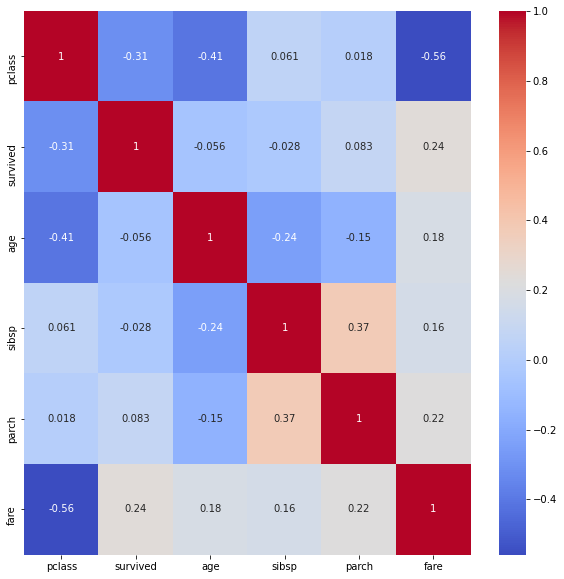

In [37]:
# correlation heatmap
sns.heatmap(df_imp.corr(), cmap='coolwarm', annot=True)

In [38]:
# one hot encode `sex`, `embarked`, `title` features
# df_imp_enc = pd.get_dummies(df_imp, columns=['sex', 'embarked', 'title'], drop_first=True)
# df_imp_enc.head()

### Use `datawig` to impute `age`

This method works very well with categorical, continuous, and non-numerical features. Datawig is a library that learns ML models using Deep Neural Networks to impute missing values in the datagram. Source: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

In [39]:
# impute missing values
df_with_missing_imputed = datawig.SimpleImputer.complete(df_imp)

In [40]:
df_imp.head(20)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck
0,1,1,female,29.0000,0,0,211.3375,S,Miss,B
1,1,1,male,0.9167,1,2,151.5500,S,Master,C
2,1,0,female,2.0000,1,2,151.5500,S,Miss,C
3,1,0,male,30.0000,1,2,151.5500,S,Mr,C
4,1,0,female,25.0000,1,2,151.5500,S,Mrs,C
5,1,1,male,48.0000,0,0,26.5500,S,Mr,E
6,1,1,female,63.0000,1,0,77.9583,S,Miss,D
7,1,0,male,39.0000,0,0,0.0000,S,Mr,A
8,1,1,female,53.0000,2,0,51.4792,S,Mrs,C
9,1,0,male,71.0000,0,0,49.5042,C,Mr,NaN


In [41]:
df_with_missing_imputed.head(20)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck
0,1.0,1.0,female,29.00000,0.0,0.0,211.3375,S,Miss,B
1,1.0,1.0,male,0.91670,1.0,2.0,151.5500,S,Master,C
2,1.0,0.0,female,2.00000,1.0,2.0,151.5500,S,Miss,C
3,1.0,0.0,male,30.00000,1.0,2.0,151.5500,S,Mr,C
4,1.0,0.0,female,25.00000,1.0,2.0,151.5500,S,Mrs,C
5,1.0,1.0,male,48.00000,0.0,0.0,26.5500,S,Mr,E
6,1.0,1.0,female,63.00000,1.0,0.0,77.9583,S,Miss,D
7,1.0,0.0,male,39.00000,0.0,0.0,0.0000,S,Mr,A
8,1.0,1.0,female,53.00000,2.0,0.0,51.4792,S,Mrs,C
9,1.0,0.0,male,71.00000,0.0,0.0,49.5042,C,Mr,NaN


### Imputation quality (`age`)

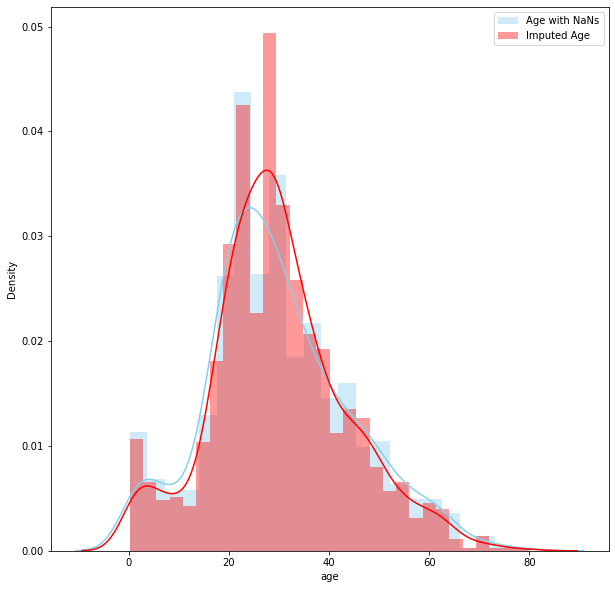

In [42]:
# distplot for `age` and `age_imp`
sns.distplot(df_imp['age'] , color="skyblue", label='Age with NaNs')
sns.distplot(df_with_missing_imputed['age'] , color="red", label='Imputed Age')
plt.legend()

In [56]:
deck_nan = df_with_missing_imputed[df_with_missing_imputed['deck'].isnull()]

In [57]:
deck_nan

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck
9,1.0,0.0,male,71.000000,0.0,0.0,49.5042,C,Mr,NaN
13,1.0,1.0,female,26.000000,0.0,0.0,78.8500,S,Miss,NaN
15,1.0,0.0,male,46.411680,0.0,0.0,25.9250,S,Mr,NaN
23,1.0,1.0,female,42.000000,0.0,0.0,227.5250,C,Miss,NaN
25,1.0,0.0,male,25.000000,0.0,0.0,26.0000,C,Mr,NaN
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,female,14.500000,1.0,0.0,14.4542,C,Miss,NaN
1305,3.0,0.0,female,17.498078,1.0,0.0,14.4542,C,Miss,NaN
1306,3.0,0.0,male,26.500000,0.0,0.0,7.2250,C,Mr,NaN
1307,3.0,0.0,male,27.000000,0.0,0.0,7.2250,C,Mr,NaN


In [58]:
# instantiate  model  and  train  imputer
model = datawig.SimpleImputer(
    input_columns = ['survived', 'age', 'fare', 'title'], 
    output_column = 'deck').fit(df_with_missing_imputed)

In [59]:
# imputing missing values in `deck`
deck_imputed = model.predict(deck_nan)

In [60]:
deck_imputed.head(10)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck,deck_imputed,deck_imputed_proba
9,1.0,0.0,male,71.000000,0.0,0.0,49.5042,C,Mr,NaN,B,0.284536
13,1.0,1.0,female,26.000000,0.0,0.0,78.8500,S,Miss,NaN,B,0.324523
15,1.0,0.0,male,46.411680,0.0,0.0,25.9250,S,Mr,NaN,C,0.232340
23,1.0,1.0,female,42.000000,0.0,0.0,227.5250,C,Miss,NaN,B,0.546687
25,1.0,0.0,male,25.000000,0.0,0.0,26.0000,C,Mr,NaN,F,0.403355
35,1.0,1.0,female,45.000000,0.0,0.0,262.3750,C,Miss,NaN,B,0.650749
37,1.0,1.0,male,40.388365,0.0,0.0,26.5500,S,Mr,NaN,E,0.285986
40,1.0,0.0,male,51.193272,0.0,0.0,39.6000,C,Rare Title,NaN,B,0.383419
46,1.0,0.0,male,47.229886,0.0,0.0,31.0000,S,Mr,NaN,C,0.244527
48,1.0,1.0,female,53.000000,0.0,0.0,27.4458,C,Mrs,NaN,C,0.378446


In [61]:
deck_imputed.deck_imputed.value_counts()

F    620
E     94
G     78
A     76
C     75
D     53
B     18
Name: deck_imputed, dtype: int64

In [62]:
# add `deck_imputed` from deck_imputed to df_with_missin_data
df_with_missing_imputed['deck_imputed'] = deck_imputed['deck_imputed']

In [63]:
# `deck` fillna from `deck_imputed` imputed values
df_with_missing_imputed.deck.fillna(df_with_missing_imputed.deck_imputed, inplace=True)

# drop `deck_imputed`
df_with_missing_imputed.drop('deck_imputed', axis=1, inplace=True)

In [64]:
df_with_missing_imputed.head(20)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck
0,1.0,1.0,female,29.00000,0.0,0.0,211.3375,S,Miss,B
1,1.0,1.0,male,0.91670,1.0,2.0,151.5500,S,Master,C
2,1.0,0.0,female,2.00000,1.0,2.0,151.5500,S,Miss,C
3,1.0,0.0,male,30.00000,1.0,2.0,151.5500,S,Mr,C
4,1.0,0.0,female,25.00000,1.0,2.0,151.5500,S,Mrs,C
5,1.0,1.0,male,48.00000,0.0,0.0,26.5500,S,Mr,E
6,1.0,1.0,female,63.00000,1.0,0.0,77.9583,S,Miss,D
7,1.0,0.0,male,39.00000,0.0,0.0,0.0000,S,Mr,A
8,1.0,1.0,female,53.00000,2.0,0.0,51.4792,S,Mrs,C
9,1.0,0.0,male,71.00000,0.0,0.0,49.5042,C,Mr,B


In [66]:
df_with_missing_imputed.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
title       0
deck        0
dtype: int64

In [67]:
df_with_missing_imputed.deck.value_counts()

F    641
C    169
E    135
D     99
A     98
B     83
G     83
T      1
Name: deck, dtype: int64

In [68]:
# output to csv
df_with_missing_imputed.to_csv('df_imp_datawig.csv', index=False)

In [52]:
# split df_imp_enc
# df_train, df_test = datawig.utils.random_split(df_imp, split_ratios=[0.8, 0.2])

In [53]:
# to impute `age`, the input_columns are `survived`, `title`, `pclass`, `sibsp` and `parch` (see correlation coefficients)
#Initialize a SimpleImputer model
# imputer = datawig.SimpleImputer(
#     input_columns=['survived', 'title', 'pclass','sibsp','parch'], # column(s) containing information about the column we want to impute
#     output_column= 'age', # the column we'd like to impute values for
#     output_path = 'imputer_model' # stores model data and metrics
#     )

In [54]:
# fit an imputer model on the train data
# imputer.fit(train_df=df_train, num_epochs=50)

In [55]:
# impute missing values and return original dataframe with predictions
# imputed = imputer.predict(df_test)

In [56]:
# imputed.head(10)

In [57]:
# imputed.shape